In [52]:
import tensorflow as tf
import os 
import time
import glob
import matplotlib.pyplot as plt
import PIL
from IPython import display
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from PIL import Image

In [53]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [54]:
(train_images, _), (test_images, _) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# 标准化图片到区间 [0., 1.] 内
train_images /= 255.
test_images /= 255.

# # 二值化
# train_images[train_images >= .5] = 1.
# train_images[train_images < .5] = 0.
# test_images[test_images >= .5] = 1.
# test_images[test_images < .5] = 0.
# ランダム
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [55]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [64]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  # squares = keras.losses.mean_squared_error(x,x_logit)
  # logpx_z = tf.reduce_sum(squares,[1,2])
  # logpz = log_normal_pdf(z, 0., 0.)
  # logqz_x = log_normal_pdf(z, mean, logvar)
  # return tf.reduce_mean(logpx_z + logqz_x)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [65]:
epochs = 10
latent_dim = 50
num_examples_to_generate = 16

# 保持随机向量恒定以进行生成（预测），以便更易于看到改进。
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [66]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout 最小化两个子图之间的重叠
  plt.savefig('./graf/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  return predictions

Epoch: 3, Test set ELBO: -134.22779846191406, time elapse for current epoch 2.178295612335205


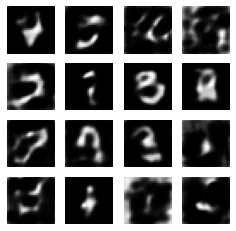

KeyboardInterrupt: 

In [67]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

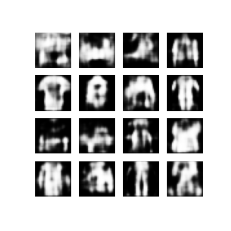

In [10]:
plt.imshow(display_image(epochs))
plt.axis('off')# 显示图片

In [24]:
model.inference_net.summary()
model.generative_net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               230500    
Total params: 249,316
Trainable params: 249,316
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1568)              79968     
__________________________

(1, 50)


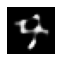

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[3.53586930e-03],
         [1.21394311e-04],
         [3.26882691e-05],
         [3.06951115e-05],
         [8.30392237e-05],
         [2.13570267e-04],
         [7.24121172e-04],
         [6.67941233e-04],
         [2.88951705e-04],
         [7.28785890e-05],
         [7.41075346e-05],
         [3.65925771e-05],
         [1.42091167e-05],
         [5.49314427e-06],
         [1.29355049e-05],
         [2.93615904e-05],
         [1.32269444e-04],
         [2.55029765e-04],
         [1.53898296e-03],
         [1.35746785e-03],
         [2.81362096e-04],
         [6.79208097e-05],
         [7.78123867e-05],
         [6.67629211e-05],
         [6.46978660e-05],
         [2.66065999e-05],
         [3.46931629e-05],
         [8.62170593e-04]],

        [[8.07013130e-05],
         [5.15430486e-07],
         [5.85268616e-08],
         [7.02748366e-08],
         [2.33874658e-07],
         [1.57871898e-06],
         [7.40820587e-06

In [10]:

random_vector_for_generation = tf.random.normal(shape=[1, 50])
print(random_vector_for_generation.shape)
generate_and_save_images(model, 51, random_vector_for_generation)

In [11]:
i=0
print(random_vector_for_generation.shape)
for t in test_dataset:
    for x in t:
        # mean, logvar = model.encode(x)
        print(x.shape)
        # print(logvar.shape)
        # print(mean.shape)
        if i == 0:
            break

(1, 50)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28,

In [12]:
xx = tf.reshape(x,[1,28,28,1])
mean, logvar = model.encode(xx)


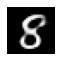

In [13]:
num =model.reparameterize(mean, logvar)
fig =generate_and_save_images(model, 51, num)

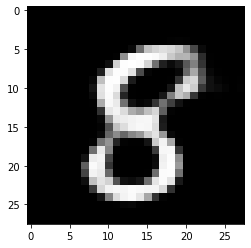

In [14]:
plt.imshow(fig[0, :, :, 0], cmap='gray')


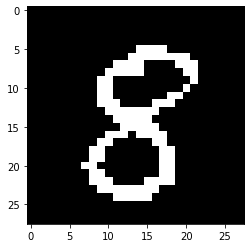

In [15]:
plt.imshow(x[:,:,0],cmap='gray')

In [23]:
noise_factor = 0.2
x_train_noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape) 

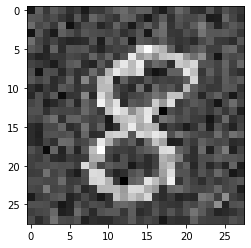

In [24]:
plt.imshow(x_train_noisy[:,:,0],cmap='gray')

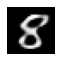

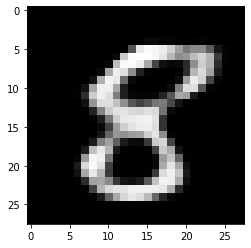

In [25]:
zz = tf.reshape(x_train_noisy,[1,28,28,1])
mean, logvar = model.encode(zz)
num =model.reparameterize(mean, logvar)
fig =generate_and_save_images(model, 52, num)
plt.imshow(fig[0, :, :, 0], cmap='gray')

In [30]:
test_np = np.stack(list(test_dataset))
test_np.shape
test_np[1][0].shape

(28, 28, 1)

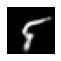

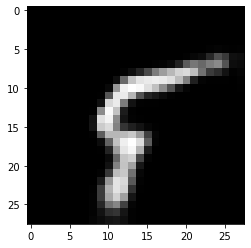

In [33]:
a =test_np[1][0]
xx = tf.reshape(a,[1,28,28,1])
mean, logvar = model.encode(xx)
num =model.reparameterize(mean, logvar)
fig =generate_and_save_images(model, 52, num)
plt.imshow(fig[0, :, :, 0], cmap='gray')

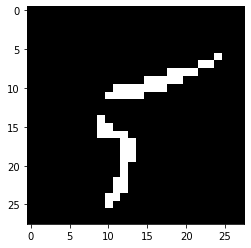

In [34]:
plt.imshow(a[:,:,0],cmap='gray')

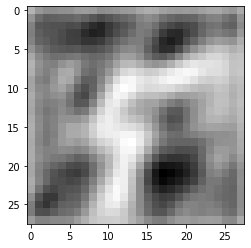

In [41]:
# compute_loss(model,xx)
mean, logvar = model.encode(xx)
z = model.reparameterize(mean, logvar)
x_logit = model.decode(z)
plt.imshow(x_logit[0, :, :, 0], cmap='gray')

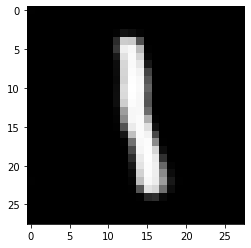

In [50]:
a =test_np[1][3]
xx = tf.reshape(a,[1,28,28,1])
mean, logvar = model.encode(xx)
num =model.reparameterize(mean, logvar)
x_logit = model.decode(mean,apply_sigmoid=True)
plt.imshow(x_logit[0, :, :, 0], cmap='gray')

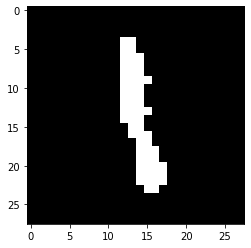

In [51]:
plt.imshow(xx[0, :, :, 0], cmap='gray')

In [ ]:
  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs